In [1]:
import os
import sys
sys.path.append('./src')
sys.path.append('../../') # to get bindings
#sys.path.append('./dependencies/indy-ros2/indy_description/urdf_files')

from utils import *
from gato_mpc import *
from gato_mpc_batch import *
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import meshcat.geometry as g
import meshcat.transformations as tf
import numpy as np
np.set_printoptions(linewidth=99999999)

# Load robot model
model_dir = "description/"
urdf_path = model_dir + "indy7.urdf"
model, visual_model, collision_model = load_robot_model(urdf_path, model_dir)
model.gravity = pin.Motion.Zero()

# Create MPC solver and optimizer
#controller = MPC_GATO(model, N=32, dt=0.01)
controller = MPC_GATO_Batch(model, N=32, dt=0.03, batch_size=1)


In [2]:
# initial state
#xstart = np.zeros(controller.nx)
xstart = np.hstack((np.ones(controller.nq), np.zeros(controller.nv)))

# goal ee positions
endpoints = np.array([
    np.array(controller.eepos(np.zeros(controller.nq))),
    np.array(controller.eepos(0.9*np.ones(controller.nq))),
    #np.array(controller.eepos(np.zeros(controller.nq))), 
    np.array(controller.eepos(np.array([-3.0, 1.0, 1.0, 1.0, 0.0, 0.0])))
])

# Run MPC
q_trajectory, mpc_stats = controller.run_mpc(xstart, endpoints, 2)

Running MPC with 200 steps, sim_dt: 0.01
Endpoints:
[[ 1.51468905e-10 -1.86500000e-01  1.26750000e+00]
 [-3.30300965e-01 -7.70697477e-01  5.35912990e-01]
 [ 8.90168461e-01  2.30300636e-01  4.67093951e-01]]
t:    0.000, goal dist:  1.07009
t:    0.050, goal dist:  1.08139
t:    0.100, goal dist:  1.10996
t:    0.200, goal dist:  1.12689
t:    0.350, goal dist:  0.88809
t:    0.400, goal dist:  0.73554
t:    0.550, goal dist:  0.29069
Reached intermediate goal 1, moving to next goal: [-0.33030096 -0.77069748  0.53591299  0.          0.          0.        ]
t:    0.700, goal dist:  1.06289
t:    0.800, goal dist:  1.04428
t:    0.950, goal dist:  0.75165
t:    1.100, goal dist:  0.37836
t:    1.150, goal dist:  0.31897
t:    1.350, goal dist:  0.26721
t:    1.400, goal dist:  0.26678
t:    1.600, goal dist:  0.31868
t:    1.650, goal dist:  0.33096
t:    1.900, goal dist:  0.35123
Maximum steps reached without convergence


In [1]:
for key in mpc_stats:
    print(key)
    print(mpc_stats[key])

NameError: name 'mpc_stats' is not defined

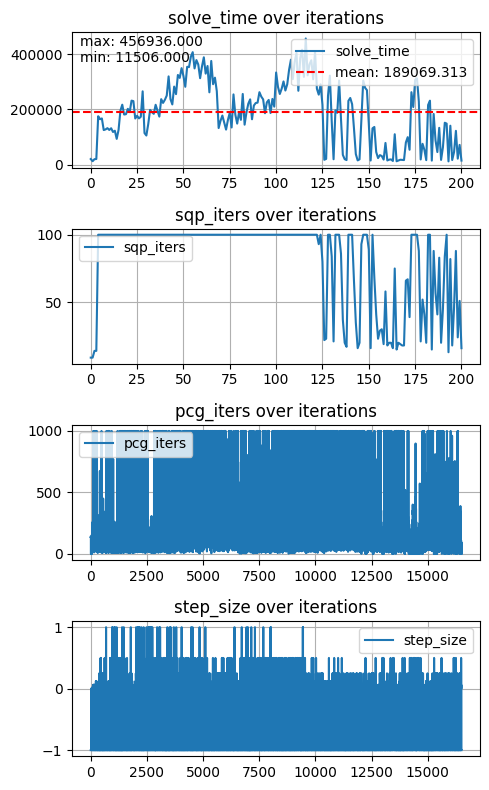

In [3]:
stats = controller.solver.get_stats()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(stats), 1, figsize=(5, 2*len(stats)))
if len(stats) == 1:
    axs = [axs]

for i, (key, data) in enumerate(stats.items()):
    ax = axs[i]
    if isinstance(data, dict) and 'values' in data:
        values = data['values']
        ax.plot(values, label=key)
        ax.set_title(f'{key} over iterations')
        if key == 'solve_time':
            ax.axhline(np.mean(values), color='r', linestyle='--', label=f'mean: {np.mean(values):.3f}')
            ax.text(0.02, 0.98, f'max: {np.max(values):.3f}\nmin: {np.min(values):.3f}', 
                   transform=ax.transAxes, verticalalignment='top')
    else:
        ax.plot(data, label=key)
        ax.set_title(f'{key} over iterations')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
    

In [4]:
# Setup pinocchio visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)
viz.initViewer()
viz.loadViewerModel()
# Visualize goals
for i, p in enumerate(endpoints):
    viz.viewer[f'point{i}'].set_object(
        g.Sphere(0.05), 
        g.MeshLambertMaterial(color=0xff0000))

    T = tf.translation_matrix(np.array(p[:]))
    viz.viewer[f'point{i}'].set_transform(T)
#print_stats(controller.solver.get_stats())
while 1:
    viz.play(q_trajectory=q_trajectory, dt=0.01)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


KeyboardInterrupt: 

In [5]:
import pickle

print(q_trajectory)

# save trajectory to file
with open('q_trajectory.pkl', 'wb') as f:
    pickle.dump(q_trajectory, f)

[array([-0.10000215, -0.09995034, -0.10001428, -0.09973532, -0.10049627, -0.09970045]), array([-0.09999626, -0.0998874 , -0.10006218, -0.09946834, -0.1010091 , -0.09937014]), array([-0.09995853, -0.09966929, -0.10040356, -0.09892561, -0.10215607, -0.09848081]), array([-0.09993001, -0.09951316, -0.10071102, -0.09867053, -0.10275819, -0.09793127]), array([-0.10019403, -0.09893406, -0.10222653, -0.09829681, -0.10427466, -0.09615428]), array([-0.1005488 , -0.0984754 , -0.10358971, -0.09826648, -0.10516703, -0.09485713]), array([-0.10239259, -0.09691284, -0.10887264, -0.09938004, -0.10757959, -0.08959294]), array([-0.10401465, -0.09575326, -0.11306962, -0.10072823, -0.10908071, -0.08537751]), array([-0.10919641, -0.09250383, -0.12536881, -0.10528646, -0.11285667, -0.07426548]), array([-0.11285042, -0.09038437, -0.13363976, -0.10860579, -0.11509966, -0.06769667]), array([-0.12233224, -0.08490463, -0.1553781 , -0.11750124, -0.11957864, -0.05210192]), array([-0.12813764, -0.08150659, -0.168991